In [1]:
%matplotlib inline

import os
import cv2
import torch
import torchvision
import numpy as np

from pdb import set_trace as bp
from parse_config import hparam as config
from models import ResNet18
from data import TorchDatasets, BaseDataLoader
from utils import *
from trainer import fit

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

/workspace/home/harv/Desktop/EVA4.0/GenericPyTorch_GradCAM/Egs/parse_config.py:37: YAMLLoadWarning: calling yaml.load_all() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  for doc in docs:


In [3]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

In [4]:
trainset = TorchDatasets('CIFAR10', './data', True, True).dataset
testset = TorchDatasets('CIFAR10', './data', False, True).dataset

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_transform_dict = {'HorizontalFlip': {'p': 0.5},
                        'PadIfNeeded': {'min_height': 40, 'min_width': 40}, 
                        'RandomCrop': {'height': 32, 'width': 32},
                        'Cutout': {'num_holes': 2, 'max_h_size': 8, 'max_w_size': 8, 'fill_value': 127.5},
                        'Normalize': {'mean': (0.5,0.5,0.5), 'std': (0.5,0.5,0.5)}}

test_transform_dict = {'Normalize': {'mean': (0.5,0.5,0.5), 'std': (0.5,0.5,0.5)}}

train_album_compose = getCompose_simple(train_transform_dict)
test_album_compose = getCompose_simple(test_transform_dict)

setattr(trainset, 'transform', train_album_compose)
setattr(testset, 'transform', test_album_compose)

In [6]:
model = ResNet18().to(device)

In [7]:
trainloader = BaseDataLoader(trainset,
                              batch_size=config.train.batch_size,
                              shuffle=config.train.shuffle,
                              num_workers=config.train.loader_workers)
testloader = BaseDataLoader(testset,
                              batch_size=config.val.batch_size,
                              shuffle=config.val.shuffle,
                              num_workers=config.val.loader_workers)              

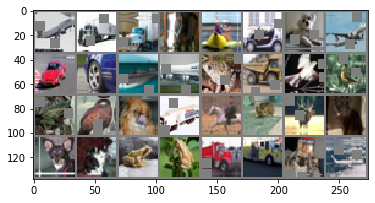

In [8]:
images, labels = iter(trainloader).next()
imshow(torchvision.utils.make_grid(images))

In [23]:
# Uncomment below to get summary of the model
# get_summary(model, (3,32,32))

In [9]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-7, momentum=0.9)


Learning rate search finished. See the graph with {finder_name}.plot()


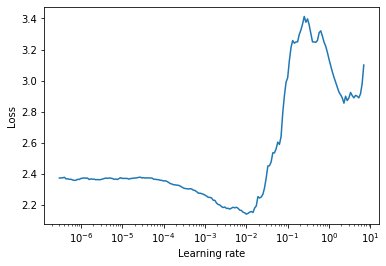

2.1400561597343817 0.009120108393559097


In [10]:
bestloss, lr_from_finder = finderplot_getlr(model, trainloader, optimizer, criterion, 10, 200, device)
print(bestloss, lr_from_finder)

# Reset the optimizer with new learning rate from LR Finder
optimizer = torch.optim.SGD(model.parameters(), lr=lr_from_finder, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0)

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:2427: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


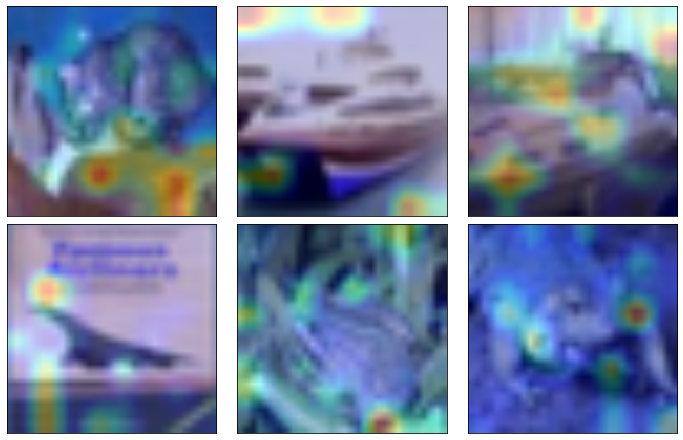

In [11]:
# GradCAM before training, on a few sample images. 
# Create the GradCam object and pass the layer you are interested to visualize 
#   according to the naming in model.named_modules()
grad_cam = GradCam(model,
                   target_layer_names=["layer3.1.conv2"],
                   use_cuda=use_cuda)

images, labels = iter(testloader).next()

# print GradCAM visualisation for one batch of images
returned_outputs = grad_cam(images[:6],
         dataset_mean=[0.5, 0.5, 0.5],
         dataset_std=[0.5, 0.5, 0.5],
         index=None,
         display=True,
         columns=3,
         rows=2)


In [12]:
train_acc, train_losses, test_acc, test_losses, misclassified_list = fit(trainloader,
                                                                          testloader,
                                                                          model,
                                                                          config.train.epochs,
                                                                          optimizer,                                    
                                                                          criterion,
                                                                          device,
                                                                          scheduler=scheduler,
                                                                          snapshot_path=os.path.join(config.model.snapshot_path, "checkpoint_check"))

  0%|          | 0/1563 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.7019108533859253 Batch_id=1562 Accuracy=44.53: 100%|██████████| 1563/1563 [02:17<00:00, 11.75it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Here 0.0037237612209381006

Test set: Average loss: 1.1655, Accuracy: 5940/10000 (59.40%)

Val loss lowered, saving weights of this epoch!

EPOCH: 1


Loss=29.52828598022461 Batch_id=1562 Accuracy=33.29: 100%|██████████| 1563/1563 [02:17<00:00, 11.38it/s] 
  0%|          | 0/1563 [00:00<?, ?it/s]

Here 0.004767627420516822

Test set: Average loss: 1.4923, Accuracy: 4721/10000 (47.21%)

EPOCH: 2


Loss=18.79513168334961 Batch_id=1562 Accuracy=51.76: 100%|██████████| 1563/1563 [02:17<00:00, 11.57it/s] 
  0%|          | 0/1563 [00:00<?, ?it/s]

Here 0.003715388066471575

Test set: Average loss: 1.1629, Accuracy: 5803/10000 (58.03%)

Val loss lowered, saving weights of this epoch!

EPOCH: 3


Loss=15.719400405883789 Batch_id=1562 Accuracy=56.44: 100%|██████████| 1563/1563 [02:16<00:00, 11.44it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Here 0.0034473487985019866

Test set: Average loss: 1.0790, Accuracy: 6102/10000 (61.02%)

Val loss lowered, saving weights of this epoch!

EPOCH: 4


Loss=15.756778717041016 Batch_id=1562 Accuracy=60.44: 100%|██████████| 1563/1563 [02:15<00:00, 11.57it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Here 0.003049573384306301

Test set: Average loss: 0.9545, Accuracy: 6588/10000 (65.88%)

Val loss lowered, saving weights of this epoch!

EPOCH: 5


Loss=18.89828109741211 Batch_id=1562 Accuracy=64.04: 100%|██████████| 1563/1563 [02:14<00:00, 11.62it/s] 
  0%|          | 0/1563 [00:00<?, ?it/s]

Here 0.002714654192756921

Test set: Average loss: 0.8497, Accuracy: 6981/10000 (69.81%)

Val loss lowered, saving weights of this epoch!

EPOCH: 6


Loss=12.254395484924316 Batch_id=1562 Accuracy=67.30: 100%|██████████| 1563/1563 [02:15<00:00, 11.57it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Here 0.0025131809907980238

Test set: Average loss: 0.7866, Accuracy: 7185/10000 (71.85%)

Val loss lowered, saving weights of this epoch!

EPOCH: 7


Loss=25.81316566467285 Batch_id=1562 Accuracy=70.20: 100%|██████████| 1563/1563 [02:15<00:00, 11.62it/s] 
  0%|          | 0/1563 [00:00<?, ?it/s]

Here 0.0022733819672093986

Test set: Average loss: 0.7116, Accuracy: 7493/10000 (74.93%)

Val loss lowered, saving weights of this epoch!

EPOCH: 8


Loss=14.083881378173828 Batch_id=1562 Accuracy=72.72: 100%|██████████| 1563/1563 [02:14<00:00, 11.59it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Here 0.002109619066585748

Test set: Average loss: 0.6603, Accuracy: 7653/10000 (76.53%)

Val loss lowered, saving weights of this epoch!

EPOCH: 9


Loss=17.392087936401367 Batch_id=1562 Accuracy=75.53: 100%|██████████| 1563/1563 [02:18<00:00, 11.30it/s]


Here 0.0019360357488687047

Test set: Average loss: 0.6060, Accuracy: 7866/10000 (78.66%)

Val loss lowered, saving weights of this epoch!



Text(0.5, 1.0, 'Test Accuracy vs Epochs')

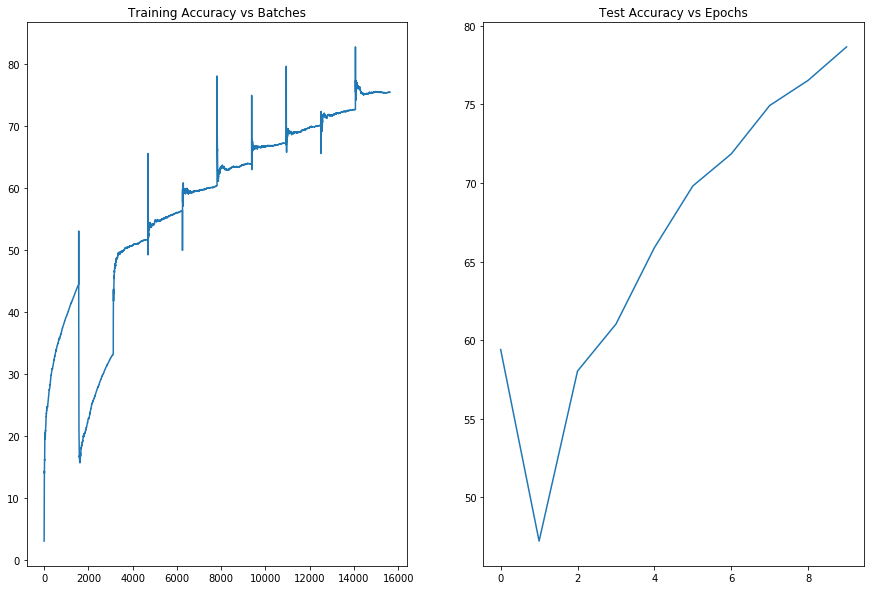

In [14]:
fig, axs = plt.subplots(1,2,figsize=(15,10))
axs[0].plot(train_acc)
axs[0].set_title("Training Accuracy vs Batches")

axs[1].plot(test_acc)
axs[1].set_title("Test Accuracy vs Epochs")

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:2427: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


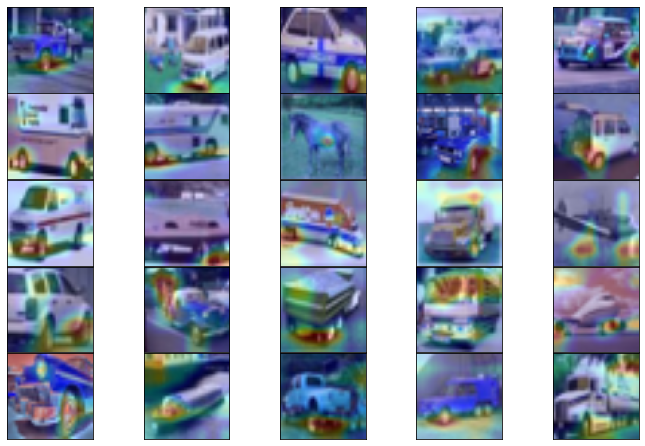

In [15]:
grad_cam = GradCam(model,            
                   target_layer_names=["layer3.1.conv2"],
                   use_cuda=use_cuda,
                   weights_path='/workspace/home/harv/Desktop/EVA4.0/GenericPyTorch_GradCAM/Egs/saves/checkpoint_check/10.pth')

# Printing gradcam for top 25 misclassified images
len_mis_images = len(misclassified_list)
mis_imagelist = [misclassified_list[i][0].cpu() for i in range(len_mis_images)]  

mis_images = torch.stack(mis_imagelist)

returned_outputs_after_training = grad_cam(mis_images,
                                            dataset_mean=[0.5, 0.5, 0.5],
                                            dataset_std=[0.5, 0.5, 0.5],
                                            index=None,
                                            columns=5,
                                            rows=5)

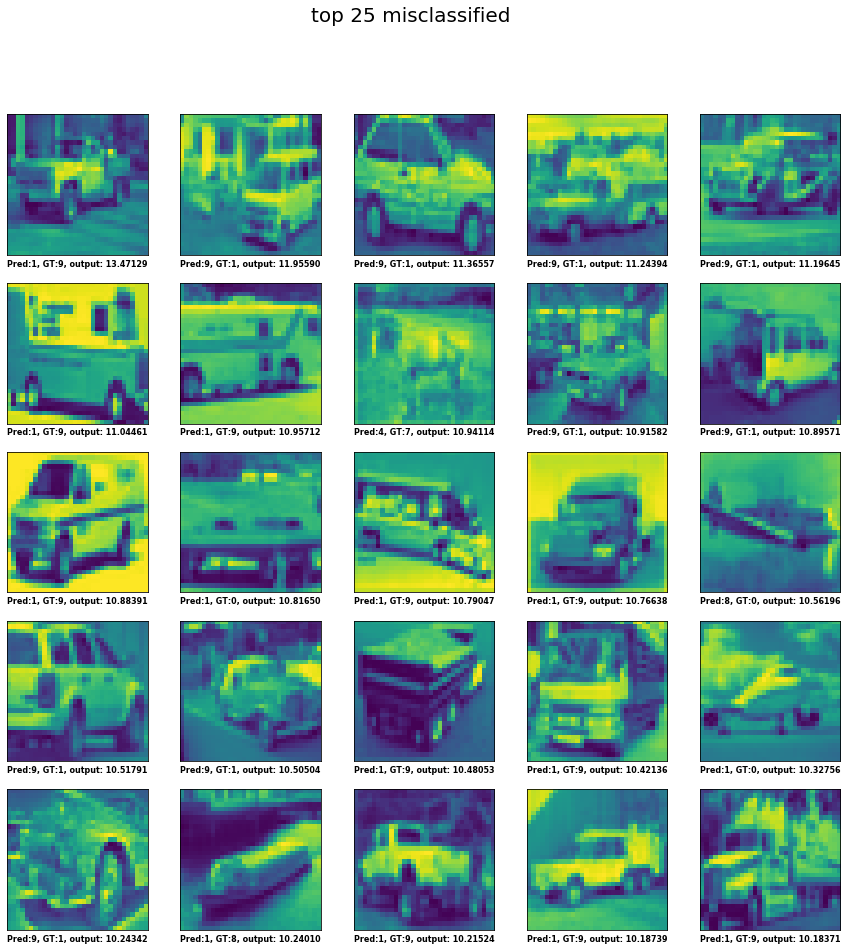

In [16]:
# Printing top 25 misclassified images
columns = 5
rows = 5 
fig=plt.figure(figsize=(15, 15))
for i in range(1, columns*rows +1):
    img = misclassified_list[i-1][0].cpu().numpy()[0]
    fig.add_subplot(rows, columns, i)
    fig.suptitle("top 25 misclassified", fontsize=20, horizontalalignment='center')
    xlabel = "Pred:{}, GT:{}, output: {:.5f}".format(misclassified_list[i-1][1], misclassified_list[i-1][3], misclassified_list[i-1][2])
    plt.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    plt.xlabel(xlabel, fontsize=8, color = 'black', fontweight='bold', horizontalalignment='center')
    plt.imshow(img)

plt.show()